# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [70]:
import tarfile

import sns as sns
import wget

url = 'http://www.soshnikov.com/permanent/data/petfaces.tar.gz'
filename = wget.download(url)

tar = tarfile.open(filename, 'r:gz')
tar.extractall()
tar.close()

Для визуализации списка изображений можно использовать такую функцию:

In [3]:
import matplotlib.pyplot as plt

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

In [4]:
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

DATASET_PATH = "petfaces"
IMG_SIZE = 128

def load_dataset(type=None):
    images = []
    labels = []
    for dirname in os.listdir(DATASET_PATH):
        for filename in os.listdir(os.path.join(DATASET_PATH, dirname)):
            img = Image.open(os.path.join(DATASET_PATH, dirname, filename))
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img_array = np.array(img)
            images.append(img_array)
            if type == 'multi':
                labels.append(dirname)
            else:
                if "cat" in dirname:
                    labels.append(0)
                else:
                    labels.append(1)
    return np.array(images), np.array(labels)

def split_dataset(images, labels):
    return train_test_split(images, labels, test_size=0.2, random_state=42)

def preprocess_dataset(type=None):
    images, labels = load_dataset(type)
    # if type == 'multi':
    #     labels = label_encoder.fit_transform(labels)
    # else:
    #     labels = labels.reshape((-1, 1))
    images = images.astype('float32') / 255.0
    return split_dataset(images, labels)

In [60]:
from keras.utils import to_categorical

label_encoder = LabelEncoder()

X_train, X_test, y_train, y_test = preprocess_dataset(type='multi')
num_classes = len(os.listdir('petfaces'))
train_labels_encoded = to_categorical(y_train, num_classes)
test_labels_encoded = to_categorical(y_test, num_classes)


In [61]:
from keras.optimizers import Adam
from keras import Model
from keras.layers import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50

def train_classifier(base_model, train_images, train_labels_encoded, num_classes):
    base_model = base_model(include_top=False, weights='imagenet')

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_images, train_labels_encoded, epochs=10, batch_size=32)

    return model

In [31]:
model16 = train_classifier(VGG16, X_train, train_labels_encoded, num_classes)
model19 = train_classifier(VGG19, X_train, train_labels_encoded, num_classes)
modelResnet = train_classifier(ResNet50, X_train, train_labels_encoded, num_classes)

Epoch 1/10
81/81 [==============================] - 73s 896ms/step - loss: 2.5898 - accuracy: 0.3153
Epoch 2/10
81/81 [==============================] - 69s 849ms/step - loss: 1.4350 - accuracy: 0.5893
Epoch 3/10
81/81 [==============================] - 74s 915ms/step - loss: 1.0533 - accuracy: 0.7042
Epoch 4/10
81/81 [==============================] - 74s 913ms/step - loss: 0.8675 - accuracy: 0.7361
Epoch 5/10
81/81 [==============================] - 76s 942ms/step - loss: 0.7358 - accuracy: 0.7882
Epoch 6/10
81/81 [==============================] - 76s 941ms/step - loss: 0.6322 - accuracy: 0.8116
Epoch 7/10
81/81 [==============================] - 77s 953ms/step - loss: 0.5692 - accuracy: 0.8299
Epoch 8/10
81/81 [==============================] - 78s 964ms/step - loss: 0.4963 - accuracy: 0.8533
Epoch 9/10
81/81 [==============================] - 79s 981ms/step - loss: 0.4554 - accuracy: 0.8645
Epoch 10/10
80134624/80134624 [==============================] - 739s 9us/step
Epoch 1/10
8

In [43]:
from sklearn.metrics import accuracy_score

test_predictions = model16.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
accuracy = accuracy_score(y_test, test_predictions)
print(f'VGG16 accuracy: {accuracy}')

test_predictions = model19.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
accuracy = accuracy_score(y_test, test_predictions)
print(f'VGG19 accuracy: {accuracy}')

test_predictions = modelResnet.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
accuracy = accuracy_score(y_test, test_predictions)
print(f'Resnet accuracy: {accuracy}')

21/21 [==============================] - 16s 755ms/step
VGG16 accuracy: 0.7480559875583204
21/21 [==============================] - 21s 996ms/step
VGG19 accuracy: 0.6936236391912908
21/21 [==============================] - 12s 587ms/step
Resnet accuracy: 0.2161741835147745


In [69]:
import cv2

def classify_image(image_path, model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    image = image.astype('float32')
    image /= 255.0

    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    predicted_class = np.argmax(predictions)
    class_label = label_encoder.inverse_transform([predicted_class])[0]

    return class_label

classify_image('petfaces/dog_staffordshire/staffordshire_bull_terrier_10.jpg', model16)

1/1 [==============================] - 0s 74ms/step


'dog_staffordshire'

In [62]:
X_train_binary, X_test_binary, y_train_binary, y_test_binary = preprocess_dataset(type='binary')
train_labels_encoded_binary = to_categorical(y_train_binary, 2)
test_labels_encoded_binary = to_categorical(y_test_binary, 2)

model16_binary = train_classifier(VGG16, X_train_binary, train_labels_encoded_binary, 2)

Epoch 1/10
81/81 [==============================] - 67s 826ms/step - loss: 0.1786 - accuracy: 0.9295
Epoch 2/10
81/81 [==============================] - 80s 992ms/step - loss: 0.0714 - accuracy: 0.9739
Epoch 3/10
81/81 [==============================] - 81s 1s/step - loss: 0.0568 - accuracy: 0.9813
Epoch 4/10
81/81 [==============================] - 82s 1s/step - loss: 0.0470 - accuracy: 0.9798
Epoch 5/10
81/81 [==============================] - 81s 1s/step - loss: 0.0625 - accuracy: 0.9751
Epoch 6/10
81/81 [==============================] - 82s 1s/step - loss: 0.0378 - accuracy: 0.9829
Epoch 7/10
81/81 [==============================] - 85s 1s/step - loss: 0.0339 - accuracy: 0.9879
Epoch 8/10
81/81 [==============================] - 82s 1s/step - loss: 0.0275 - accuracy: 0.9907
Epoch 9/10
81/81 [==============================] - 83s 1s/step - loss: 0.0224 - accuracy: 0.9922
Epoch 10/10
81/81 [==============================] - 84s 1s/step - loss: 0.0164 - accuracy: 0.9957


In [63]:
test_predictions = model16_binary.predict(X_test_binary)
test_predictions = np.argmax(test_predictions, axis=1)
accuracy = accuracy_score(y_test_binary, test_predictions)
print(accuracy)

21/21 [==============================] - 17s 773ms/step
0.9766718506998445


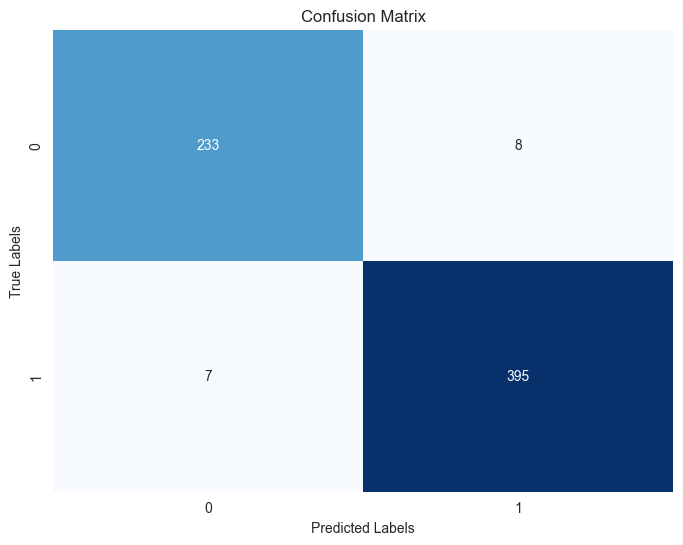

In [64]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_binary, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()